In [22]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [23]:
# Load dataset (replace 'IBM.csv' with your dataset path)
dataset = pd.read_csv('data/rnn/IBM.csv', index_col="Date", parse_dates=["Date"])

dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


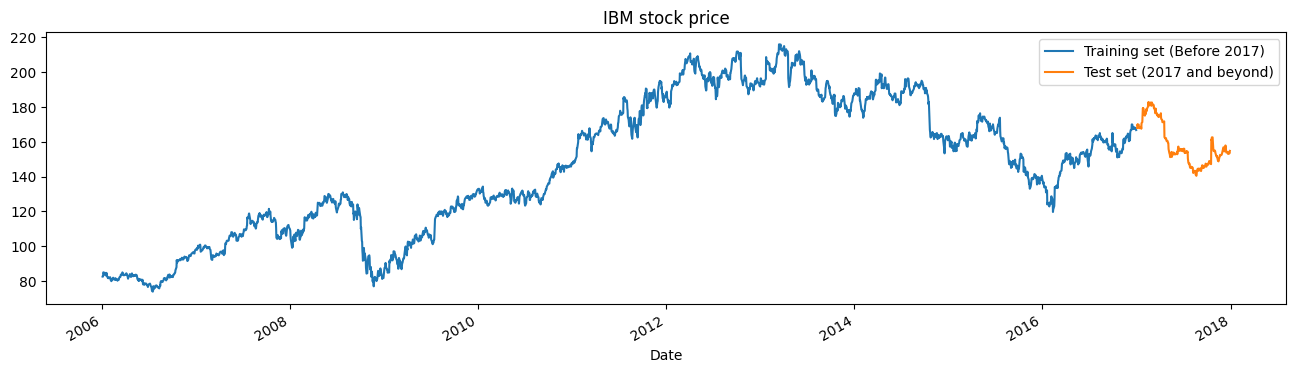

In [24]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [25]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.transform(test_set)

In [26]:
def create_sequence(training_set, window_size=60):
    X_train = np.array([training_set[i - window_size:i, 0] for i in range(window_size, len(training_set))])
    y_train = np.array([training_set[i, 0] for i in range(window_size, len(training_set))])
    return X_train, y_train

X_train, y_train = create_sequence(training_set_scaled, window_size=60)

In [27]:
X_train = torch.tensor(np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)), dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, num_layers=4):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, dropout=0.1)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])  # Take the last time-step output
        return predictions

In [29]:
net = NeuralNetRegressor(
    LSTMModel,
    max_epochs=100,
    lr=0.001,
    batch_size=32,
    optimizer=torch.optim.Adam,
    train_split=None,  # Disabling skorch train/validation split
)

In [30]:
net.fit(X_train, y_train)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.0256  2.6102
      2        0.0635  2.5360
      3        0.0781  2.5191
      4        0.0951  2.5652
      5        0.0954  2.4863
      6        0.0684  2.5092
      7        0.0650  2.4878
      8        0.0825  2.4649
      9        0.0954  2.4506
     10        0.0932  2.4639
     11        0.0899  3.6205
     12        0.0890  4.0953
     13        0.0883  3.0160
     14        0.0878  3.7750
     15        0.0872  3.9825
     16        0.0867  3.8492
     17        0.0863  3.4918
     18        0.0861  2.8060
     19        0.0857  2.4623
     20        0.0855  2.4818
     21        0.0854  2.5062
     22        0.0853  2.4973
     23        0.0853  2.4836
     24        0.0850  2.5012
     25        0.0846  2.4751
     26        0.0844  2.4720
     27        0.0841  2.4826
     28        0.0839  2.5284
     29        0.0839  2.5163
     30        0.0837  2.4750
     31        0.0835  2.4689
     32   

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=LSTMModel(
    (lstm): LSTM(1, 50, num_layers=4, batch_first=True, dropout=0.1)
    (linear): Linear(in_features=50, out_features=1, bias=True)
  ),
)

In [31]:
# Preparing X_test and predicting the prices
X_test, _ = create_sequence(test_set_scaled)
X_test = torch.tensor(np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1)), dtype=torch.float32)
predicted_stock_price = net.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

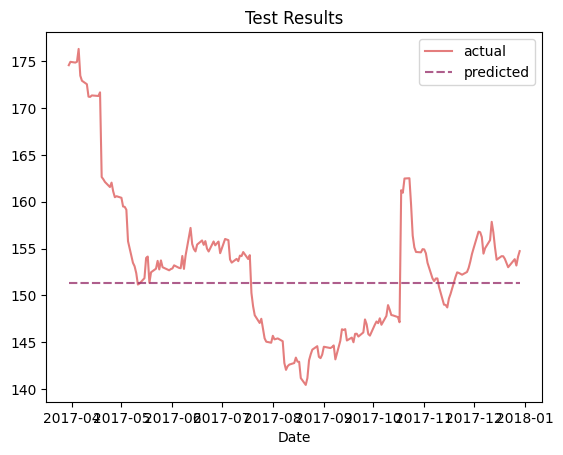

In [32]:
import seaborn as sns

df_pred = pd.DataFrame(dataset["High"]["2017":])
df_pred.columns=["actual"]
df_pred = df_pred[60:]
df_pred["predicted"] = predicted_stock_price

plt.title("Test Results")
sns.lineplot(df_pred,alpha=0.8,palette="flare",linestyle=None);

In [33]:
from sklearn.metrics import root_mean_squared_error
def return_rmse(test,predicted):
    rmse = root_mean_squared_error(test, predicted)
    print("The root mean squared error is {}.".format(rmse))

In [34]:
return_rmse(predicted_stock_price, df_pred["actual"])

The root mean squared error is 7.706443464870382.
